In [5]:
# 신경망
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
import dezero.functions as F

![그림 43-1](./img/43-1.png)    
linear처럼 사용 시 메모리를 더 효율적으로

In [6]:
from dezero.core import Function, Variable, as_variable, as_array

class Linear(Function):
    def forward(self, x, W, b):
        y = x.dot(W)
        if b is not None:
            y += b
        return y

    def backward(self, gy):
        x, W, b = self.inputs
        gb = None if b.data is None else sum_to(gy, b.shape)
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW, gb

def linear(x, W, b=None):
    return Linear()(x, W, b)

def linear_simple(x, W, b=None):
    t = matmul(x, W)
    print(f't {type(t)}')
    if b is None:
        return t

    y = t + b
    t.data = None  # Release t.data (ndarray) for memory efficiency
    return y

# chainer는 Aggressive Buffer Release 사용
# https://docs.google.com/document/d/1CxNS2xg2bLT9LoUe6rPSMuIuqt8Gbkz156LTPJPT3BE/edit#

In [14]:
np.random.seed(0)
x = np.random.rand(100, 1)                          
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)          # 비선형 데이터셋

x.shape

(100, 1)

신경망은 선형 변환의 출력에 비선형 변환을 수행. (비선형 변환 = 활성화 함수)    
대표적으로 ReLU와 sigmoid가 있다     
![식 43.1](./img/43.1.png)  
![그림 43-3](./img/43-3.png)

In [8]:
# 시그모이드 함수
def sigmoid_simple(x):
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y

# 시그모이드 개선
class Sigmoid(Function):
    def forward(self, x):
        xp = cuda.get_array_module(x)
        # y = 1 / (1 + xp.exp(-x))
        y = xp.tanh(x * 0.5) * 0.5 + 0.5  # Better implementation
        return y

    def backward(self, gy):
        y = self.outputs[0]()
        gx = gy * y * (1 - y)
        return gx


def sigmoid(x):
    return Sigmoid()(x)

In [17]:
I, H, O = 1, 10, 1
W1 = Variable(0.01 * np.random.randn(I, H)) # (1, 10), 가중치는 랜덤으로
b1 = Variable(np.zeros(H))                  # (10,)
W2 = Variable(0.01 * np.random.randn(H, O)) # (10, 1), 가중치는 랜덤으로
b2 = Variable(np.zeros(O))                  # (1,)



def predict(x):                 # 2층 신경망
    y = F.linear(x, W1, b1)    
    # (100,1) * (1, 10) + (10, ) = (100, 10)
    y = F.sigmoid(y)           
    # (100, 10)
    y = F.linear(y, W2, b2)   
    # (100, 10) * (10, 1) + (1, ) = (100, 1)
    return y

lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()

    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    if i % 1000 == 0:
        print(f'W1 : {W1.data}, b1 : {b1.data}, w2 : {W2.data}, b2 : {b2.data}, loss : {loss}')


W1 : [[-0.00814881 -0.00689008 -0.00463214  0.00033506 -0.00367422 -0.01372178
  -0.00644026 -0.02235536  0.00630667 -0.01603839]], b1 : [-6.10891136e-04  2.88551875e-05 -4.09090396e-04  8.53520993e-04
 -7.15145806e-04  1.47719420e-04 -2.17293475e-05 -6.46130550e-04
  2.89451243e-04 -9.48909571e-05], w2 : [[0.09950304]
 [0.11108035]
 [0.10318738]
 [0.12606228]
 [0.09766498]
 [0.11315802]
 [0.11017064]
 [0.09871845]
 [0.11592803]
 [0.10874846]], b2 : [0.22126064], loss : variable(0.8593119652336929)
W1 : [[-0.67659375 -1.14071595 -0.68506215 -1.42710118 -0.32636497 -1.46813667
  -1.08649359 -1.25909168 -0.77495264 -1.39365582]], b1 : [-0.06705836  0.00693032 -0.06730717  0.17825989 -0.02585478  0.21156387
 -0.01321024  0.064188   -0.06711807  0.15252882], w2 : [[ 0.26833136]
 [ 0.77656449]
 [ 0.27723088]
 [ 1.11690658]
 [-0.09102799]
 [ 1.16605444]
 [ 0.71423584]
 [ 0.91512791]
 [ 0.37204394]
 [ 1.0763443 ]], b2 : [-1.97098488], loss : variable(0.2527540406362989)
W1 : [[-0.66790145 -1.

(100, 1)
(100, 1)
(1, 100)


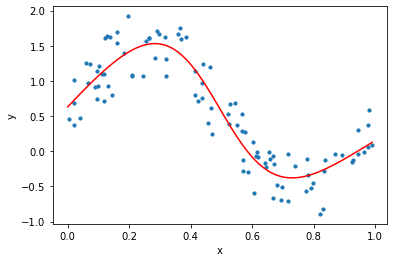

In [11]:
# Plot
plt.scatter(x, y, s=10)
plt.xlabel('x')
plt.ylabel('y')
t = np.arange(0, 1, .01)[:, np.newaxis]
            
print(np.arange(0, 1, .01)[:, np.newaxis].shape)   # (100,1) 열 부분에 np.newaxis를 입력시, 차원을 분해한 후 한 단계 추가합니다.
print(np.arange(0, 1, .01)[np.newaxis, :].shape)  # (1,100) 행 부분에 np.newaxis를 입력시, 차원을 한 단계 추가합니다.

y_pred = predict(t)
plt.plot(t, y_pred.data, color='r')
plt.show()

In [17]:
np.arange(0, 1, .01)[:, np.newaxis].shape

(100, 1)